In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from xgboost import XGBClassifier
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
# Import Magic Kingdom attractions
mka = pd.read_csv("./attractions/attractions_mk.csv")
mka.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31039 entries, 0 to 31038
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   datetime              31039 non-null  object
 1   seven_dwarfs_train    31039 non-null  object
 2   pirates_of_caribbean  31039 non-null  object
 3   splash_mountain       31039 non-null  object
dtypes: object(4)
memory usage: 970.1+ KB


In [3]:
# mka.sort_index(inplace=True)
# mk.tail(20)

In [4]:
mka = mka[mka["datetime"] != '2019-12-31 01:00:00']
mka = mka[mka["datetime"] != '2019-12-31 00:00:00']
mka.head(2)

,datetime,seven_dwarfs_train,pirates_of_caribbean,splash_mountain
0,2015-01-01 07:00:00,45.0,na,5.0
1,2015-01-01 08:00:00,78.0,na,5.0


In [5]:
# Added DATE column to mk from the datetime column, using it to concat dataframes
mka['DATE'] = pd.to_datetime(mka['datetime']).dt.date
mka['DATE'] = pd.to_datetime(mka["DATE"])
print(mka.info())
mka.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31037 entries, 0 to 31038
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              31037 non-null  object        
 1   seven_dwarfs_train    31037 non-null  object        
 2   pirates_of_caribbean  31037 non-null  object        
 3   splash_mountain       31037 non-null  object        
 4   DATE                  31037 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 1.4+ MB
None


,datetime,seven_dwarfs_train,pirates_of_caribbean,splash_mountain,DATE
0,2015-01-01 07:00:00,45.0,na,5.0,2015-01-01
1,2015-01-01 08:00:00,78.0,na,5.0,2015-01-01


In [6]:
# Import Metadata
md = pd.read_csv("./metadata/mk_metadata.csv")
md.head(2)

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,HOLIDAY,WDWevent,...,MKDAYSBEFORENONEVENT,MKDAYSSINCENONEVENT,MKEVENTSTREAK,MKEVENTSTREAK_F,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_MK,CapacityLostWGT_MK
0,2015-01-01,5,0,0,1,2015,0,5,1,0,...,1.0,1,0,0,53.375714,70.3,50.2,0.12,616246,53904354
1,2015-01-02,6,1,0,1,2015,2,5,0,0,...,1.0,1,0,0,53.750714,70.3,50.0,0.12,616246,53904354


In [7]:
# Convert DATE column to datetime
md['DATE'] = pd.to_datetime(md["DATE"])
md.head(2)

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,HOLIDAY,WDWevent,...,MKDAYSBEFORENONEVENT,MKDAYSSINCENONEVENT,MKEVENTSTREAK,MKEVENTSTREAK_F,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_MK,CapacityLostWGT_MK
0,2015-01-01,5,0,0,1,2015,0,5,1,0,...,1.0,1,0,0,53.375714,70.3,50.2,0.12,616246,53904354
1,2015-01-02,6,1,0,1,2015,2,5,0,0,...,1.0,1,0,0,53.750714,70.3,50.0,0.12,616246,53904354


In [8]:
# Merge mka and md dataframes
mk = pd.merge(mka, md, how='outer', on='DATE')

In [9]:
# Dropped hours when park is closed
mk['datetime'] = pd.to_datetime(mk["datetime"])
mk[mk['datetime'].dt.hour >= 7]
# Dropped unneeded Date column
mk.drop('DATE', axis = 1,  inplace = True)

In [10]:
# Set datetime to the Index and sorted by it
# mk.set_index('datetime', inplace=True)
# mk.sort_index(inplace=True)
# mk.head(2)

In [11]:
# # Set 23:59 as closing time for closings after 23:00 to make datetime work
# for col in ['MKOPEN', 'MKCLOSE',  'MKEMHOPEN', 'MKEMHCLOSE',
#        'MKOPENYEST', 'MKCLOSEYEST', 'MKOPENTOM',
#        'MKCLOSETOM','SUNSET_WDW']:
#     mk[col] = np.where(mk[col] == "24:00",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "27:00",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "26:00",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "25:00",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "23:55",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "29:59",'23:59' ,mk[col])
# #     mk[col] = np.where(mk[col] == "30:00",'23:59' ,mk[col])

In [12]:
for col in ['MKOPEN', 'MKCLOSE',  'MKEMHOPEN', 'MKEMHCLOSE',
       'MKOPENYEST', 'MKCLOSEYEST', 'MKOPENTOM',
       'MKCLOSETOM','SUNSET_WDW']:
    mk[col] = mk[col].str.replace(":","")

In [13]:
mk.fillna(0, inplace=True)
# mk.isnull().sum()

In [14]:
for col in ['MKOPEN', 'MKCLOSE',  'MKEMHOPEN', 'MKEMHCLOSE',
       'MKOPENYEST', 'MKCLOSEYEST', 'MKOPENTOM',
       'MKCLOSETOM','SUNSET_WDW']:
    mk[col] = mk[col].astype(int)

In [15]:
# Formatted the times in the inSession tolumns for floats
for col in ['inSession', 'inSession_Enrollment', 'inSession_wdw',
       'inSession_sqrt_WDW', 'inSession_DC', 'inSession_Central_FL',
       'inSession_Drive1_FL', 'inSession_Drive2_FL',
       'inSession_Florida', 'inSession_Mardi_Gras', 'inSession_Midwest',
       'inSession_NY_NJ', 'inSession_NY_NJ_PA', 'inSession_New_England',
       'inSession_New_Jersey', 'inSession_Nothwest', 'INSESSION_PLANES',
       'inSession_SoCal', 'inSession_Southwest']:
    mk[col] = mk[col].str.replace(r'%', r'').astype('float')/-100

In [16]:
# Changed the values to floats
for col in ['seven_dwarfs_train', "pirates_of_caribbean", "splash_mountain"]:
    mk[col] = pd.to_numeric(mk[col],errors='coerce')
mk.fillna(0, inplace=True)

In [17]:
# Dummified the WDWSEASON column
mk = pd.get_dummies(mk,columns = ['WDWSEASON'])

In [18]:
# Created new column for hour as a feature
mk['hour'] = mk.datetime.dt.hour
mk.fillna(0, inplace=True)
# 
# mk['hour'] = pd.Datetimeindex(sales['timestamp']).hour
# mk['hour'] = mk.hour.str[11:13]
# mk['hour'] = pd.to_numeric(mk['hour'])*100

# mk.tail(2)

In [19]:
# Changed the datetime column to the index
mk.set_index('datetime', inplace=True)
mk.head(2)

,seven_dwarfs_train,pirates_of_caribbean,splash_mountain,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00,45.0,0.0,5.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,7
2015-01-01 08:00:00,78.0,0.0,5.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,8


In [20]:
# Viewing the available columns/features
mk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31037 entries, 2015-01-01 07:00:00 to 2019-12-30 06:00:00
Data columns (total 85 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   seven_dwarfs_train                       31037 non-null  float64
 1   pirates_of_caribbean                     31037 non-null  float64
 2   splash_mountain                          31037 non-null  float64
 3   DAYOFWEEK                                31037 non-null  int64  
 4   DAYOFYEAR                                31037 non-null  int64  
 5   WEEKOFYEAR                               31037 non-null  int64  
 6   MONTHOFYEAR                              31037 non-null  int64  
 7   YEAR                                     31037 non-null  int64  
 8   HOLIDAYPX                                31037 non-null  int64  
 9   HOLIDAYM                                 31037 non-null  int64  
 10  HOLIDAY    

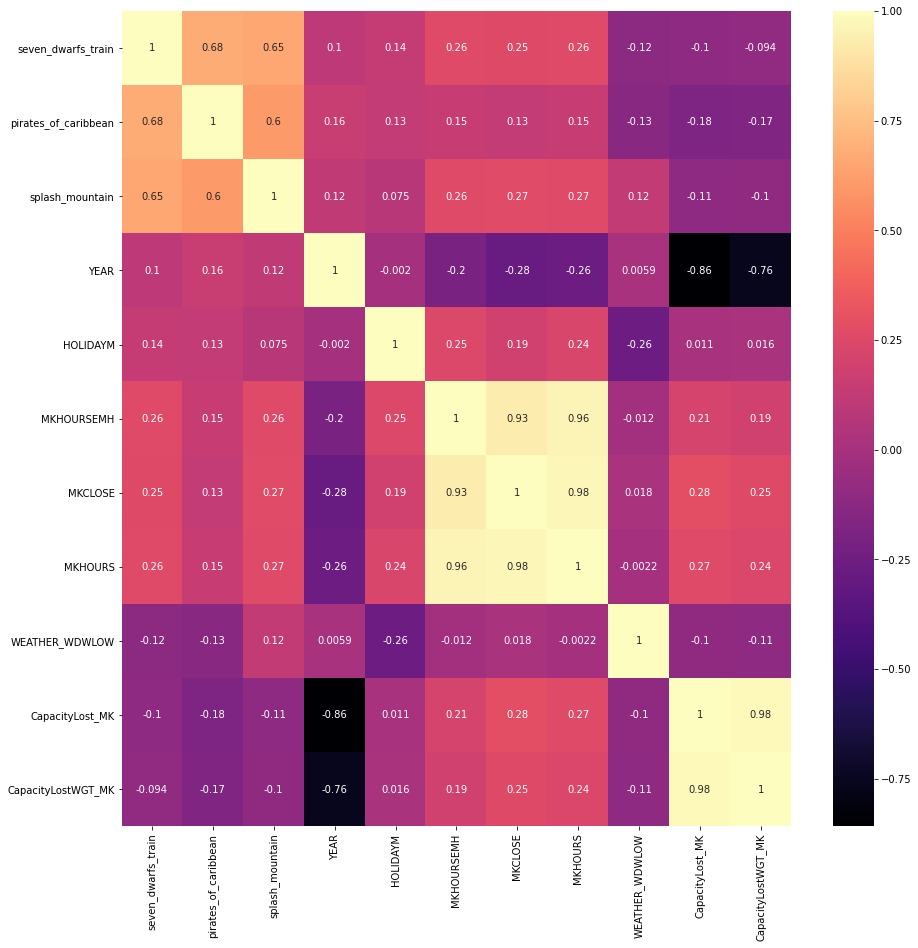

In [21]:
top_corr = mk.corr()
top_corr_features = top_corr.index[abs(top_corr["pirates_of_caribbean"]) > .13]
plt.figure(figsize=(15,15))
g = sns.heatmap(mk[top_corr_features].corr(),annot=True,cmap="magma")

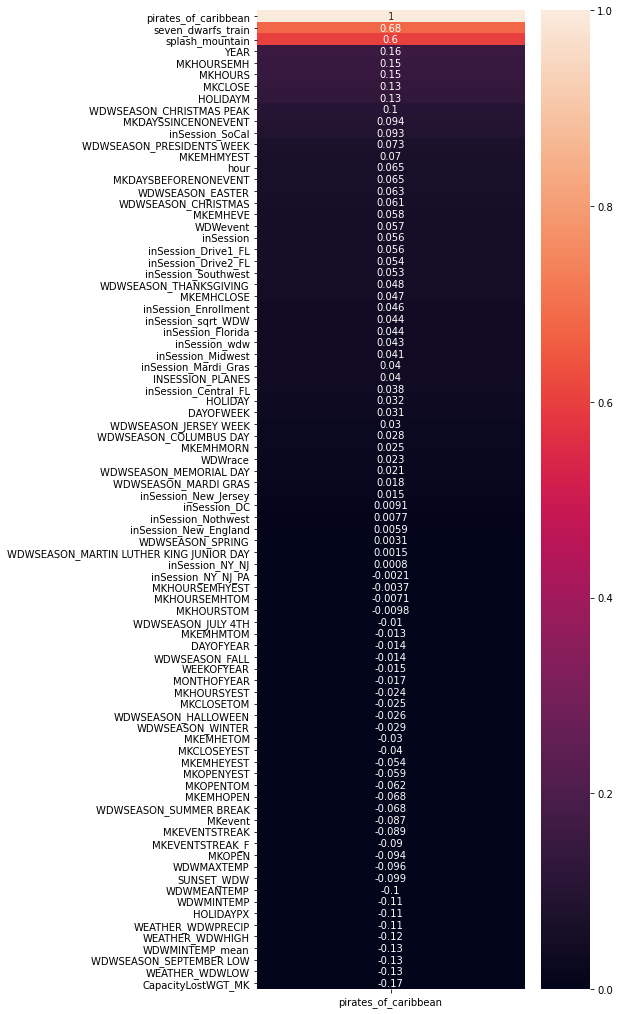

In [22]:
corr = mk.corr()
plt.figure(figsize = (6,18))
sns.heatmap(corr[['pirates_of_caribbean']].sort_values(by = 'pirates_of_caribbean', ascending = False).head(84),vmin = 0, annot = True)
plt.show()

In [27]:
# Set Features as columns to use for X variable, set y 
features = [
#             'splash_mountain', 'seven_dwarfs_train', 
#             'CapacityLostWGT_MK','inSession',
#             "MKCLOSE", 'MKOPEN','MKHOURS',,'HOLIDAYM'
            'hour','YEAR','DAYOFWEEK',"MONTHOFYEAR",'DAYOFYEAR','WEEKOFYEAR',
#             'WDWSEASON_CHRISTMAS', 'WDWSEASON_CHRISTMAS PEAK',
#             'WDWSEASON_COLUMBUS DAY', 'WDWSEASON_EASTER', 'WDWSEASON_FALL',
#             'WDWSEASON_HALLOWEEN', 'WDWSEASON_JERSEY WEEK', 'WDWSEASON_JULY 4TH',
#             'WDWSEASON_MARDI GRAS', 'WDWSEASON_MARTIN LUTHER KING JUNIOR DAY',
#             'WDWSEASON_MEMORIAL DAY', 'WDWSEASON_PRESIDENTS WEEK',
#             'WDWSEASON_SEPTEMBER LOW', 'WDWSEASON_SPRING', 'WDWSEASON_SUMMER BREAK',
#             'WDWSEASON_THANKSGIVING', 'WDWSEASON_WINTER',
            ]
y = mk['pirates_of_caribbean']
X = mk[features]

In [28]:
# Test train split, fit and transform the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.02, random_state=2020)
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

# Linear Regression

In [29]:
# Created my model and started the train test split
linreg = LinearRegression()
linreg.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# Predict on the training data
linreg_preds_train = linreg.predict(X_train_sc)
linreg_rms_train = sqrt(mean_squared_error(y_train, linreg_preds_train))
linreg_rms_train

17.91023525944283

In [31]:
# Score the testing data
linreg_preds_test = linreg.predict(X_test_sc)
linreg_rms_test = sqrt(mean_squared_error(y_test, linreg_preds_test))
linreg_rms_test

17.61938434309246

In [32]:
11.82

11.82

## KNN

In [33]:
# Instiantiated KNN and fitted the training
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [34]:
# Predict on the training data
knn_preds_train = knn.predict(X_train_sc)
knn_rms_train = sqrt(mean_squared_error(y_train, knn_preds_train))
knn_rms_train

6.815672500640055

In [35]:
# Score the testing data
knn_preds_test = knn.predict(X_test_sc)
knn_rms_test = sqrt(mean_squared_error(y_test, knn_preds_test))
knn_rms_test


8.780735757946806

In [36]:
8.58

8.58

## Decision Tree Model

In [37]:
# Instiantiate model and fit the Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train_sc, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [38]:
# Predict on the training data
dt_preds_train = dt.predict(X_train_sc)
dt_rms_train = sqrt(mean_squared_error(y_train, dt_preds_train))
dt_rms_train

0.0

In [39]:
# Score the testing data
dt_preds_test = dt.predict(X_test_sc)
dt_rms_test = sqrt(mean_squared_error(y_test, dt_preds_test))
dt_rms_test

9.512006143267845

In [40]:
11.92

11.92

## Bagged Decision Tree

In [41]:
# Instiantiate model and fit the Bagged Decision Tree
bag = BaggingRegressor()
bag.fit(X_train_sc, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [42]:
# Predict on the training data
bag_preds_train = bag.predict(X_train_sc)
bag_rms_train = sqrt(mean_squared_error(y_train, bag_preds_train))
bag_rms_train

3.4353114954855632

In [43]:
# Score the testing data
bag_preds_test = bag.predict(X_test_sc)
bag_rms_test = sqrt(mean_squared_error(y_test, bag_preds_test))
bag_rms_test

8.046751477445701

In [44]:
8.60

8.6

## Random Forests

In [45]:
# Instiantiate model and fit
rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
# Predict on the training data
rf_preds_train = rf.predict(X_train_sc)
rf_rms_train = sqrt(mean_squared_error(y_train, rf_preds_train))
rf_rms_train

2.912177316506927

In [47]:
# Score the testing data
rf_preds_test = rf.predict(X_test_sc)
rf_rms_test = sqrt(mean_squared_error(y_test, rf_preds_test))
rf_rms_test

7.935562975766183

In [48]:
7.88

7.88

## ADA boost

In [49]:
# Instiantiate model and fit
ada = AdaBoostRegressor()
ada.fit(X_train_sc, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [50]:
# Predict on the training data
ada_preds_train = ada.predict(X_train_sc)
ada_rms_train = sqrt(mean_squared_error(y_train, ada_preds_train))
ada_rms_train

13.257254297627142

In [51]:
# Score the testing data
ada_preds_test = ada.predict(X_test_sc)
ada_rms_test = sqrt(mean_squared_error(y_test, ada_preds_test))
ada_rms_test

12.995132415940098

In [52]:
12.17

12.17

## SVM

In [53]:
# Instiantiate model and fit
svr = svm.SVR()
svr.fit(X_train_sc, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [54]:
# Predict on the training data
svr_preds_train = svr.predict(X_train_sc)
svr_rms_train = sqrt(mean_squared_error(y_train, svr_preds_train))
svr_rms_train

12.623097702883825

In [55]:
# Score the testing data
svr_preds_test = svr.predict(X_test_sc)
svr_rms_test = sqrt(mean_squared_error(y_test, svr_preds_test))
svr_rms_test

12.321583522348515

In [56]:
10.61

10.61

# XG Boost

In [57]:
# # Set X and y variables
# features = ['splash_mountain', 'seven_dwarfs_train', 'inSession',
#             'YEAR', 'MKHOURS', 'DAYOFWEEK','HOLIDAYM','MKOPEN',
#             "MONTHOFYEAR",'DAYOFYEAR','hour']
# y = mk['pirates_of_caribbean']
# X = mk[features]

In [58]:
# Set Features as columns to use for X variable, set y 
features = [
#             'splash_mountain', 'seven_dwarfs_train', 
#             'CapacityLostWGT_MK','inSession',
#             "MKCLOSE", 'MKOPEN','MKHOURS',,'HOLIDAYM'
            'hour','YEAR','DAYOFWEEK',"MONTHOFYEAR",'DAYOFYEAR','WEEKOFYEAR',
#             'WDWSEASON_CHRISTMAS', 'WDWSEASON_CHRISTMAS PEAK',
#             'WDWSEASON_COLUMBUS DAY', 'WDWSEASON_EASTER', 'WDWSEASON_FALL',
#             'WDWSEASON_HALLOWEEN', 'WDWSEASON_JERSEY WEEK', 'WDWSEASON_JULY 4TH',
#             'WDWSEASON_MARDI GRAS', 'WDWSEASON_MARTIN LUTHER KING JUNIOR DAY',
#             'WDWSEASON_MEMORIAL DAY', 'WDWSEASON_PRESIDENTS WEEK',
#             'WDWSEASON_SEPTEMBER LOW', 'WDWSEASON_SPRING', 'WDWSEASON_SUMMER BREAK',
#             'WDWSEASON_THANKSGIVING', 'WDWSEASON_WINTER',
            ]
y = mk['pirates_of_caribbean']
X = mk[features]

In [59]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.02, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [60]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
# Predict RMSE on the training data
model_preds_train = model.predict(X_train_sc)
model_rms_train = sqrt(mean_squared_error(y_train, model_preds_train))
model_rms_train

19.7785386335466

In [62]:
# Score the testing data with RMSE
model_preds_test = model.predict(X_test_sc)
model_rms_test = sqrt(mean_squared_error(y_test, model_preds_test))
model_rms_test

20.814107070448557

In [78]:
14.90

14.9

# FBprophet

In [63]:
# Imported FBprophet at top of workbook
# Copied mk dataframe for use in FBprophet
df1 = mk[['pirates_of_caribbean']].copy()
df1 = df1[~(df1.index < '2016-01-01')] 

In [64]:
# Made a 2 column dataframe in the format FBprophet requires (ds,'y')
df = df1
df.rename(columns = {'pirates_of_caribbean':'y'}, inplace = True)
df.index.name = 'ds'
df = df.reset_index()
df['ds'] = pd.to_datetime(df["ds"])
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24865 entries, 0 to 24864
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      24865 non-null  datetime64[ns]
 1   y       24865 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 388.6 KB
None


,ds,y
0,2016-01-01 00:00:00,5.0
1,2016-01-01 01:00:00,5.0


In [65]:
df.plot(figsize=(40,10));

ValueError: view limit minimum -36871.19791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [66]:
# df['y_orig'] = df['y']
# df['y']=np.log(df['y']+1)

In [67]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True,daily_seasonality=True  )
m.add_country_holidays(country_name='US')
m.fit(df)

In [68]:
future = m.make_future_dataframe(periods=744, freq='h')
future.tail()

,ds
25604,2020-01-30 19:00:00
25605,2020-01-30 20:00:00
25606,2020-01-30 21:00:00
25607,2020-01-30 22:00:00
25608,2020-01-30 23:00:00


In [69]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)


,ds,yhat,yhat_lower,yhat_upper
25607,2020-01-30 22:00:00,3.356799,-10.563593,17.566320
25608,2020-01-30 23:00:00,0.495008,-13.716177,14.937749


In [70]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(2)

,ds,yhat,yhat_lower,yhat_upper
0,2016-01-01 00:00:00,-6.314926,-20.241779,8.063663
1,2016-01-01 01:00:00,-8.400767,-22.244069,5.396780


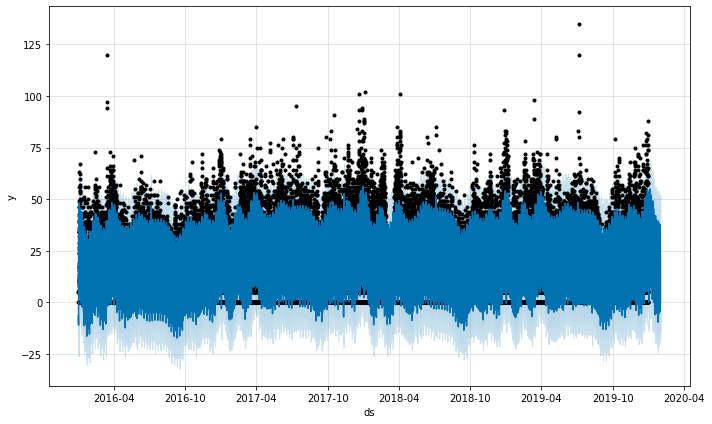

In [71]:
fig1 = m.plot(forecast)

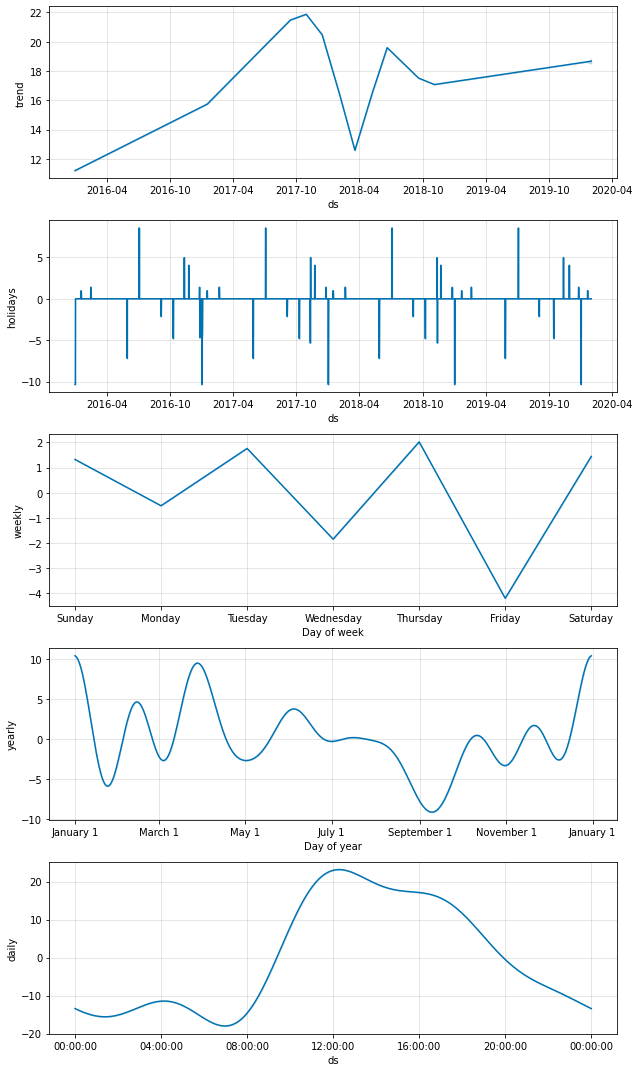

In [72]:
fig2 = m.plot_components(forecast)

In [73]:
# from fbprophet.plot import plot_plotly
# import plotly.offline as py
# py.init_notebook_mode()

# fig = plot_plotly(m, forecast)  # This returns a plotly Figure
# py.iplot(fig)


In [74]:
df_cv = cross_validation(m, initial='1095 days', period='30 days', horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 2019-01-04 23:00:00 and 2019-11-30 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-05 06:00:00,15.524389,1.540535,29.798071,0.0,2019-01-04 23:00:00
1,2019-01-05 07:00:00,13.825670,-1.378820,28.242454,0.0,2019-01-04 23:00:00
2,2019-01-05 08:00:00,17.093477,2.312057,32.430382,5.0,2019-01-04 23:00:00
3,2019-01-05 09:00:00,26.592943,13.127865,41.868664,8.0,2019-01-04 23:00:00
4,2019-01-05 10:00:00,39.209492,25.238459,53.501649,35.0,2019-01-04 23:00:00


In [75]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days 06:00:00,172.318029,13.126996,9.098368,0.398756,0.81920
1,3 days 07:00:00,172.344449,13.128002,9.103254,0.398756,0.81920
2,3 days 08:00:00,172.176739,13.121613,9.090065,0.403123,0.82016
3,3 days 09:00:00,171.795417,13.107075,9.059798,0.399910,0.82080
4,3 days 10:00:00,172.686625,13.141028,9.093040,0.393467,0.81920


In [76]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,3 days 06:00:00,172.318029,13.126996,9.098368,0.398756,0.819200
1,3 days 07:00:00,172.344449,13.128002,9.103254,0.398756,0.819200
2,3 days 08:00:00,172.176739,13.121613,9.090065,0.403123,0.820160
3,3 days 09:00:00,171.795417,13.107075,9.059798,0.399910,0.820800
4,3 days 10:00:00,172.686625,13.141028,9.093040,0.393467,0.819200
...,...,...,...,...,...,...
558,29 days 20:00:00,111.777797,10.572502,8.230368,0.387372,0.846400
559,29 days 21:00:00,113.276280,10.643133,8.302114,0.388578,0.843600
560,29 days 22:00:00,113.344550,10.646340,8.324450,0.388911,0.844800
561,29 days 23:00:00,114.240667,10.688343,8.372994,0.392278,0.843200


In [77]:
df_p.describe()

,horizon,mse,rmse,mae,mdape,coverage
count,563,563.000000,563.000000,563.000000,563.000000,563.000000
mean,16 days 15:14:36.021314,125.983140,11.169365,8.385000,0.354898,0.825890
std,7 days 17:39:04.368512,25.238215,1.109324,0.643435,0.031252,0.023394
min,3 days 06:00:00,80.069737,8.948169,6.919710,0.298293,0.782400
25%,9 days 22:30:00,111.217344,10.545963,8.097889,0.333332,0.808800
50%,16 days 16:00:00,121.937903,11.042550,8.366620,0.346333,0.824000
75%,23 days 08:30:00,140.280742,11.844017,8.855407,0.383740,0.838400
max,30 days 00:00:00,196.814021,14.029042,9.699742,0.434321,0.880000


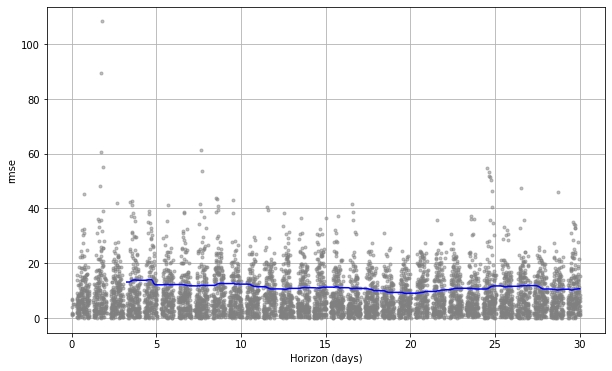

In [78]:

fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [94]:
# df2 = df.copy()
# df2['ds'] = pd.to_datetime(df2['ds'])
# df2 = df2[df2['ds'].dt.hour > 7]
# m = Prophet().fit(df2)

In [95]:
df2 = df.copy()
df2['cap'] = 120
df2['floor'] = 0
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour > 7]

m = Prophet(growth= 'logistic' )
m.add_country_holidays(country_name='US')
m = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(df2)

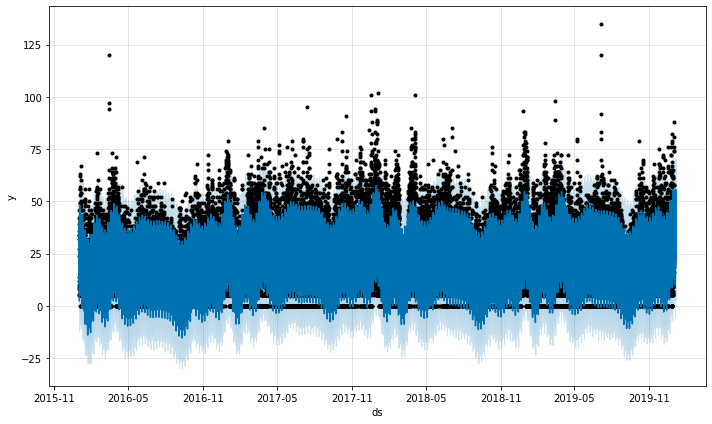

In [96]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour > 7]
future2['cap'] = 120
future2['floor'] = 0
future2 = m.make_future_dataframe(periods=119, freq='H')
fcst = m.predict(future2)
fig = m.plot(fcst)

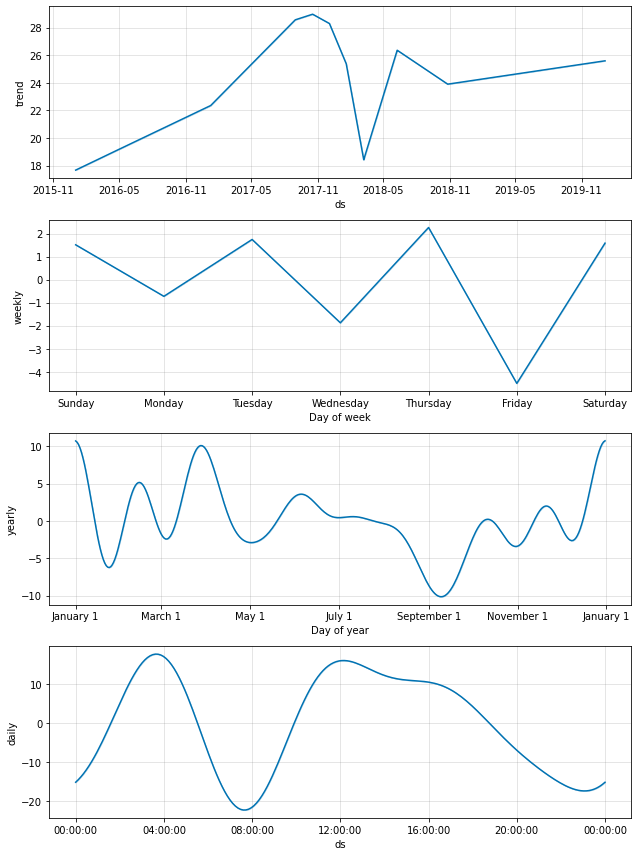

In [97]:
fig2 = m.plot_components(fcst)

In [98]:
fcst.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,...,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.000000,22880.0,22880.0,22880.0,22880.000000
mean,23.777281,9.485886,39.572302,23.777281,23.777281,0.754339,0.754339,0.754339,0.653823,0.653823,...,0.010654,0.010654,0.010654,0.089861,0.089861,0.089861,0.0,0.0,0.0,24.531620
std,2.863382,13.368511,13.367616,2.863382,2.863382,13.194042,13.194042,13.194042,12.241208,12.241208,...,2.306335,2.306335,2.306335,4.496662,4.496662,4.496662,0.0,0.0,0.0,13.349491
min,17.672000,-29.982080,-0.350211,17.672000,17.672000,-36.165412,-36.165412,-36.165412,-21.594995,-21.594995,...,-4.810337,-4.810337,-4.810337,-10.143394,-10.143394,-10.143394,0.0,0.0,0.0,-15.337263
25%,21.533925,-1.755911,28.382757,21.533925,21.533925,-10.657439,-10.657439,-10.657439,-11.642656,-11.642656,...,-1.755676,-1.755676,-1.755676,-2.424031,-2.424031,-2.424031,0.0,0.0,0.0,13.291049
50%,24.447776,11.712525,41.762016,24.447776,24.447776,3.090857,3.090857,3.090857,4.285334,4.285334,...,-0.250071,-0.250071,-0.250071,-0.054534,-0.054534,-0.054534,0.0,0.0,0.0,26.813398
75%,25.436241,20.384508,50.446175,25.436241,25.436241,11.518235,11.518235,11.518235,12.080454,12.080454,...,2.154421,2.154421,2.154421,2.251917,2.251917,2.251917,0.0,0.0,0.0,35.468548
max,28.975596,42.095112,72.691964,28.975596,28.975596,30.911304,30.911304,30.911304,17.096155,17.096155,...,4.095131,4.095131,4.095131,10.754317,10.754317,10.754317,0.0,0.0,0.0,57.445437


In [99]:
df_cv = cross_validation(m, initial='1095 days', period='30 days', horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 2019-01-04 23:00:00 and 2019-11-30 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-05 08:00:00,17.648157,2.029286,33.384513,5.0,2019-01-04 23:00:00
1,2019-01-05 09:00:00,26.354975,11.983540,41.043400,8.0,2019-01-04 23:00:00
2,2019-01-05 10:00:00,39.865802,25.015069,54.350113,35.0,2019-01-04 23:00:00
3,2019-01-05 11:00:00,50.661048,35.593927,66.360980,44.0,2019-01-04 23:00:00
4,2019-01-05 12:00:00,54.787853,39.311580,70.297246,71.0,2019-01-04 23:00:00


In [100]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-05 08:00:00,17.648157,2.029286,33.384513,5.0,2019-01-04 23:00:00
1,2019-01-05 09:00:00,26.354975,11.983540,41.043400,8.0,2019-01-04 23:00:00
2,2019-01-05 10:00:00,39.865802,25.015069,54.350113,35.0,2019-01-04 23:00:00
3,2019-01-05 11:00:00,50.661048,35.593927,66.360980,44.0,2019-01-04 23:00:00
4,2019-01-05 12:00:00,54.787853,39.311580,70.297246,71.0,2019-01-04 23:00:00
...,...,...,...,...,...,...
5613,2019-12-30 19:00:00,37.791047,21.565592,51.458567,44.0,2019-11-30 23:00:00
5614,2019-12-30 20:00:00,32.163189,17.513622,46.173651,35.0,2019-11-30 23:00:00
5615,2019-12-30 21:00:00,27.351783,12.561865,41.812610,25.0,2019-11-30 23:00:00
5616,2019-12-30 22:00:00,23.445235,8.184356,38.412880,27.0,2019-11-30 23:00:00


In [101]:
df_cv.describe()

,yhat,yhat_lower,yhat_upper,y
count,5618.000000,5618.000000,5618.000000,5618.000000
mean,25.105629,10.029891,40.183197,25.344073
std,13.316646,13.322481,13.351594,17.497323
min,-10.804617,-25.996658,3.389582,0.000000
25%,13.739640,-1.323818,28.823410,10.000000
50%,27.574485,12.555292,42.580942,24.000000
75%,35.842200,20.779600,51.043114,39.000000
max,56.261181,41.247120,72.302645,135.000000


In [102]:
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days 09:00:00,194.217961,13.936210,9.811562,0.365336,0.796791
1,3 days 10:00:00,195.186077,13.970901,9.851858,0.365336,0.795752
2,3 days 11:00:00,200.035639,14.143396,10.008470,0.366872,0.792187
3,3 days 12:00:00,202.017016,14.213269,10.052458,0.366872,0.790404
4,3 days 13:00:00,207.040635,14.388907,10.146599,0.366941,0.786542
...,...,...,...,...,...,...
427,29 days 20:00:00,119.308125,10.922826,8.625635,0.339552,0.846702
428,29 days 21:00:00,122.146825,11.052005,8.756684,0.341320,0.840463
429,29 days 22:00:00,121.165423,11.007517,8.737367,0.341320,0.844920
430,29 days 23:00:00,122.122302,11.050896,8.789156,0.346098,0.843137


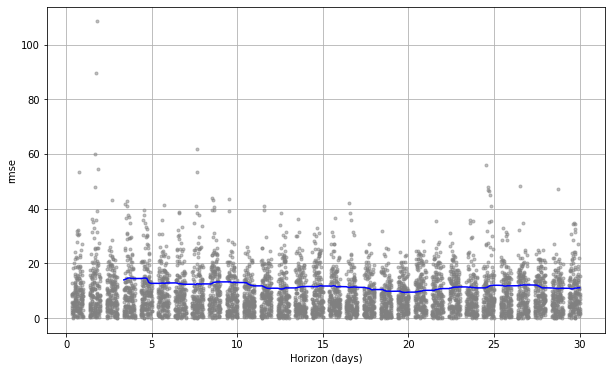

In [103]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False, random_state=42)

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
model = Sequential()
model.add(Dense(8, # How many neurons do we want in the first layer, 
               activation='relu',
               input_shape=(8,)))
model.add(Dense(1, activation=None))

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['mse'])

In [ ]:
model.fit(X_train_sc, y_train,
         epochs=10,
         batch_size=16,
         validation_data=(X_test_sc, y_test))

In [ ]:
x

In [ ]:
features = ['splash_mountain', 'seven_dwarfs_train','YEAR', 'MKHOURS', 'MKHOURSEMH', 'inSession','DAYOFWEEK' ,'HOLIDAYM' ]

y = mk['pirates_of_caribbean']
# X = mk.drop(columns='pirates_of_caribbean')
X = mk[features] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
# Create training sequences
train_seq = TimeseriesGenerator(
            X_train_sc, y_train,
            length=8,
            batch_size=64)

In [ ]:
# Create test sequences
batch_x, batch_y = train_seq[0]

In [ ]:
# train_seq[0]
# train_seq[0][0]
train_seq[0][0].shape

In [ ]:
test_seq = TimeseriesGenerator(
            X_test_sc, y_test,
            length=8,
            batch_size=64)

In [ ]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape=(8, 8), return_sequences=True))
model.add(GRU(8, return_sequences=True))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['mse'])

In [ ]:
hist = model.fit(train_seq, epochs=5, validation_data=test_seq)

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
mk.index.min()


In [ ]:
mk.index.max()

In [ ]:
features = ['splash_mountain', 'seven_dwarfs_train', 'YEAR', 'MKHOURS', 'MKHOURSEMH', 'inSession','DAYOFWEEK' ,'HOLIDAYM']
y = mk['pirates_of_caribbean']
X = mk[features]

In [ ]:
'pirates_of_caribbean'

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=('2020-03-13 21:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Wait Times')
plt.legend()
plt.show()

In [220]:
mk

,seven_dwarfs_train,pirates_of_caribbean,splash_mountain,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00,45.0,0.0,5.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,700
2015-01-01 08:00:00,78.0,0.0,5.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,800
2015-01-01 09:00:00,103.0,0.0,5.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,900
2015-01-01 10:00:00,88.0,28.0,16.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,1000
2015-01-01 11:00:00,86.0,62.0,22.0,5,0,0,1,2015,0,5,...,0,0,0,0,0,0,0,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,143.0,44.0,80.0,2,363,52,12,2019,2,5,...,0,0,0,0,0,0,0,0,0,1900
2019-12-30 20:00:00,105.0,35.0,69.0,2,363,52,12,2019,2,5,...,0,0,0,0,0,0,0,0,0,2000
2019-12-30 21:00:00,113.0,25.0,42.0,2,363,52,12,2019,2,5,...,0,0,0,0,0,0,0,0,0,2100


In [326]:
mk = mk.reset_index()
mk['datetime'] = pd.to_datetime(mk["datetime"])

In [327]:
mk

,datetime,seven_dwarfs_train,pirates_of_caribbean,splash_mountain,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
0,2015-01-01 07:00:00,45.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,700
1,2015-01-01 08:00:00,78.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,800
2,2015-01-01 09:00:00,103.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,900
3,2015-01-01 10:00:00,88.0,28.0,16.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,1000
4,2015-01-01 11:00:00,86.0,62.0,22.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31032,2019-12-30 19:00:00,143.0,44.0,80.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,1900
31033,2019-12-30 20:00:00,105.0,35.0,69.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2000
31034,2019-12-30 21:00:00,113.0,25.0,42.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2100
31035,2019-12-30 22:00:00,78.0,27.0,33.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2200


In [328]:
# # 
mk = mk[mk['datetime'].dt.hour >= 7]

# mk=mk[(mk['datetime'].dt.hour == 0)
mk

,datetime,seven_dwarfs_train,pirates_of_caribbean,splash_mountain,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
0,2015-01-01 07:00:00,45.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,700
1,2015-01-01 08:00:00,78.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,800
2,2015-01-01 09:00:00,103.0,0.0,5.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,900
3,2015-01-01 10:00:00,88.0,28.0,16.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,1000
4,2015-01-01 11:00:00,86.0,62.0,22.0,5,0,0,1,2015,0,...,0,0,0,0,0,0,0,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31032,2019-12-30 19:00:00,143.0,44.0,80.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,1900
31033,2019-12-30 20:00:00,105.0,35.0,69.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2000
31034,2019-12-30 21:00:00,113.0,25.0,42.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2100
31035,2019-12-30 22:00:00,78.0,27.0,33.0,2,363,52,12,2019,2,...,0,0,0,0,0,0,0,0,0,2200


In [329]:
pd.crosstab(mk['YEAR'], mk['hour'])

hour,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
YEAR,,,,,,,,,,,,,,,,,
2015,247,359,364,364,365,364,364,365,364,363,364,363,363,358,355,343,313
2016,250,362,365,365,365,364,365,365,365,365,365,364,364,363,362,334,284
2017,241,360,361,361,362,363,363,363,362,363,363,363,363,363,362,329,262
2018,318,363,365,365,365,365,365,365,365,365,365,365,365,365,364,331,261
2019,311,364,364,364,364,364,364,364,364,363,364,364,363,363,363,325,265
